(9218, 14) (9218, 1) (6146, 14) (6146, 1)
0.8555
(9218, 15)
adding 1, number of mapping nodes 224, number of enhence nodes 28, accuracy 0.85268
(9218, 15)
adding 2, number of mapping nodes 238, number of enhence nodes 42, accuracy 0.85257
(9218, 15)
adding 3, number of mapping nodes 252, number of enhence nodes 56, accuracy 0.8504
(9218, 15)
adding 4, number of mapping nodes 266, number of enhence nodes 70, accuracy 0.84921
(9218, 15)
adding 5, number of mapping nodes 280, number of enhence nodes 84, accuracy 0.84921
[matrix([[1.91015708]]), matrix([[1.87508672]]), matrix([[1.87314035]]), matrix([[1.87260593]]), matrix([[1.87190581]])]
[matrix([[0.09627507]]), matrix([[0.09374915]]), matrix([[0.09370012]]), matrix([[0.09371065]]), matrix([[0.09367164]])]
[0.8837832278388634, 0.8876072716232499, 0.887840481313721, 0.8879044715707304, 0.887988275873619]


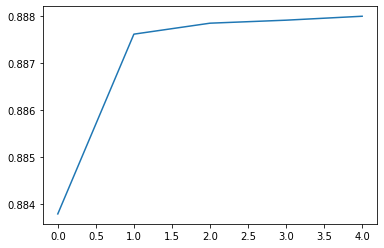

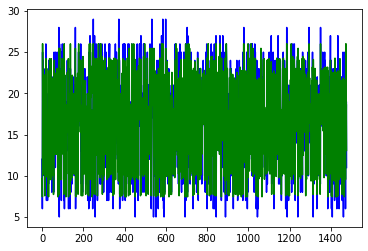

In [14]:
import numpy as np
from sklearn import preprocessing
from numpy import random
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as scio

from sklearn.metrics import r2_score

'''
本文将权值矩阵和偏置合并计算,增强层采用简便的生成方式
'''


def show_accuracy(predictLabel,Label):
    RMSE = np.sqrt((predictLabel-Label).T*(predictLabel-Label)/Label.shape[0]);
    MAPE = sum(abs(predictLabel-Label))/Label.mean()/Label.shape[0]
    R2 = r2_score(Label,predictLabel)
    return RMSE, MAPE, R2

class dataProcess:
    def __init__(self):
        self._mean = 0
        self._std = 0
        
    def pinv(self,A,reg):
        return np.mat(reg*np.eye(A.shape[1])+A.T.dot(A)).I.dot(A.T)


    '''
    参数压缩，将接近于0的参数压缩为0，减少特征
    '''
    def shrinkage(self,a,b):
        z = np.maximum(a - b, 0) - np.maximum( -a - b, 0)
        return z
    '''
    参数稀疏化：
        lasso方法来解决稀疏表示过程中的优化问题
    '''
    def sparse_bls(self,A,b):
        lam = 0.001   ########################此处可优化
        itrs = 50
        AA = np.dot(A.T,A)   
        m = A.shape[1]
        n = b.shape[1]
        wk = np.zeros([m,n],dtype = 'double')
        ok = np.zeros([m,n],dtype = 'double')
        uk = np.zeros([m,n],dtype = 'double')

        #特征提取层，利用L1正则化和L2正则化实现特征稀疏化
        L1 = np.mat(AA + np.eye(m)).I
        L2 = np.dot(np.dot(L1,A.T),b)
        for i in range(itrs):
            tempc = ok - uk
            ck =  L2 + np.dot(L1,tempc)
            ok = self.shrinkage(ck + uk, lam)
            uk += ck - ok
            wk = ok

        return wk
        

class node_generator:
    def __init__(self,whiten = False,NumWin=1):
        self.Wlist = []  #存储权值和偏置
        self.nonlinear = 0
        self.whiten = whiten
        self.distOfMaxAndMin = np.zeros(NumWin)    #记录每个窗口的最大值和最小值之差
        self.meanOfEachWindow = np.zeros(NumWin)   #记录每个窗口的平均值

        
    #四个激活函数，供增强层使用
    def sigmoid(self,data):
        return 1.0/(1+np.exp(-data))
    
    def linear(self,data):
        return data
    
    def tanh(self,data):
        return (np.exp(data)-np.exp(-data))/(np.exp(data)+np.exp(-data))
    
    def relu(self,data):
        return np.maximum(data,0)
    
    #回归中的激活函数
    def tansig(self,x):
        return (2/(1+np.exp(-2*x)))-1
    def orth(self,W):
        for i in range(0,W.shape[1]):
            w = np.mat(W[:,i].copy()).T
            w_sum = 0
            for j in range(i):
                wj = np.mat(W[:,j].copy()).T
                w_sum += (w.T.dot(wj))[0,0]*wj 
            w -= w_sum
            w = w/np.sqrt(w.T.dot(w))
            W[:,i] = np.ravel(w)
        return W
    #生成权值矩阵
    def generator(self,shape,times):
        u = 0
        for i in range(times):
            random.seed(i+u)
            W = 2*random.random(size=shape)-1
            if self.whiten == True:
                W = self.orth(W)
            yield (W)
    
    
    
    #第一次生成映射层节点
    def generator_Mapping_nodes(self, X, NumWin, NumFea):
        self.Wlist = [elem for elem in self.generator((X.shape[1],NumFea),NumWin)]
        
        y = np.zeros([X.shape[0],NumWin*NumFea])   #留着后面存储映射层所有窗口的特征节点
        
        for i in range(NumWin):
            WeightFea = self.Wlist[i]
            Z = X.dot(WeightFea)   #初步生成映射层节点
            scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Z)   #将映射层的节点的数据归一化
            Z = scaler.transform(Z)
            dataprocess = dataProcess()
            WeightFeaSparse  = dataprocess.sparse_bls(Z,X).T   #最优化权值矩阵：先通过对找到一个稀疏矩阵 W ，使H1 X W = A1
            self.Wlist[i] = WeightFeaSparse
            #print(WeightFeaSparse)
            Z = X.dot(WeightFeaSparse)
            #print(Z)
            #将T1归一化，Min_Max归一化方法
            self.meanOfEachWindow[i] = Z.mean()
            self.distOfMaxAndMin[i] = Z.max() - Z.min()
            Z = (Z - self.meanOfEachWindow[i])/self.distOfMaxAndMin[i] 
            #该操作相当于合并所有窗口
            y[:,NumFea*i:NumFea*(i+1)] = Z
        return y
    
    def generator_Enhence_nodes(self, data, NumEnhence):
        self.Wlist = [elem for elem in self.generator((data.shape[1],NumEnhence),1)]
        WeightEnhence = self.Wlist[0]
        #print(WeightEnhence.shape)
        H = data.dot(WeightEnhence)
        
        H = self.tansig(H)
        
        return H
    
    def transform_Map(self, testdata, NumWin, NumFea):
        y = np.zeros([testdata.shape[0],NumWin*NumFea])   #留着后面存储映射层所有窗口的特征节点
        for i in range(NumWin):
            WeightFea = self.Wlist[i]
            Z = testdata.dot(WeightFea)   #初步生成映射层节点
            #将T1归一化，Min_Max归一化方法
            Z = (Z - self.meanOfEachWindow[i])/self.distOfMaxAndMin[i] 
            
            #该操作相当于合并所有窗口
            y[:,NumFea*i:NumFea*(i+1)] = Z   
        return y
    
    def transform_Enh(self, testdata):
        WeightEnhence = self.Wlist[0]
        H = testdata.dot(WeightEnhence)
        
        H = self.tansig(H)
        
        return H

            
        

class broadnet:
    def __init__(self, 
                 NumWin = 10,   #映射层窗口个数
                 NumEnhence = 10,   #增强层节点个数
                 traintimes = 100,   #训练次数
                 map_function = 'linear',
                 enhence_function = 'linear',
                 NumFea = 'auto',    #映射层窗口中特征节点个数
                 acc = 1,
                 mapstep = 1,
                 enhencestep = 1,
                 reg = 2**-30):
        
        self._NumWin = NumWin
        self._NumEnhence = NumEnhence
        self._NumFea = NumFea
        self._traintimes = traintimes
        self._acc = acc
        self._mapstep = mapstep
        self._enhencestep = enhencestep
        self._reg = reg
        self._map_function = map_function
        self._enhence_function = enhence_function
                
        self.mapping_generator = node_generator(whiten=False, NumWin=self._NumWin)   #生成映射层节点用，里面分两个函数，generator_Mapping_nodes()用于第一次生成，要初始化权值矩阵和偏置，transform_Mapping()函数用于以后生成，直接使用初始化好的权值矩阵和偏置
        self.enhence_generator = node_generator(whiten = True)
        self.W = 0  #输出层权值矩阵
        self.pesuedoinverse = 0  #伪逆
        self.local_mapgeneratorlist = []
        self.local_enhgeneratorlist = []
        
    def fit(self, oridata, orilabel):
        if self._NumFea == 'auto':  #如果没有设置每个窗口的特征节点数目，则默认为训练数据的列
            self._NumFea = oridata.shape[1]
        #对训练数据增量化处理
        X = np.hstack([oridata, 0.1 * np.ones([oridata.shape[0],1])])
        mappingdata = self.mapping_generator.generator_Mapping_nodes(X, self._NumWin, self._NumFea)
       # print(mappingdata)
        #对映射层输出增量化处理
        mappingdata = np.hstack([mappingdata, 0.1 * np.ones([mappingdata.shape[0],1])])  
        enhencedata = self.enhence_generator.generator_Enhence_nodes(mappingdata, self._NumEnhence)
        #print(enhencedata)
        inputdata = np.hstack([mappingdata,enhencedata])
        
        dataprocess = dataProcess()
        #获取伪逆和输出层权值矩阵
        self.pesuedoinverse = dataprocess.pinv(inputdata,self._reg)
        self.W =  self.pesuedoinverse.dot(orilabel)
        #print(self.W)
        Y = inputdata.dot(self.W)
        accuracy, i = self.accuracy(Y,orilabel),0
        print(accuracy)
        while i < self._traintimes and accuracy < self._acc:
            Y = self.adding_predict(oridata, orilabel, self._mapstep, self._enhencestep, self._NumFea)  
            accuracy = self.accuracy(Y,orilabel)
            i += 1
            print("adding {3}, number of mapping nodes {0}, number of enhence nodes {1}, accuracy {2}".format((len(self.mapping_generator.Wlist)+len(self.local_mapgeneratorlist)*len(self.local_mapgeneratorlist[0].Wlist))*self._NumFea,(len(self.enhence_generator.Wlist)+len(self.local_enhgeneratorlist)*len(self.local_enhgeneratorlist[0].Wlist))*self._NumFea,round(accuracy,5),i))

        
    def accuracy(self, predictlabel, orilabel):
        count = 0
        orilabel = np.ravel(orilabel).tolist()
        predictlabel = np.ravel(predictlabel).tolist()
        
        for i in range(len(orilabel)):
            #print(math.fabs(orilabel[i] - predictlabel[i])/orilabel[i])
            if math.fabs(orilabel[i] - predictlabel[i])/orilabel[i] < 0.2:
                count += 1
        return (round(count/len(orilabel),5))
    
    def transform(self, testdata):
        mappingdata = self.mapping_generator.transform_Map(testdata, self._NumWin, self._NumFea)
        mappingdata = np.hstack([mappingdata, 0.1 * np.ones([mappingdata.shape[0],1])])  
        #print(mappingdata.shape)
        enhencedata = self.enhence_generator.transform_Enh(mappingdata)
        inputdata = np.hstack([mappingdata,enhencedata])
        
        for elem1,elem2 in zip(self.local_mapgeneratorlist,self.local_enhgeneratorlist):
            inputdata  = np.column_stack((inputdata, elem1.transform_Map(testdata,self._mapstep,self._NumFea)))
            inputdata  = np.column_stack((inputdata, elem2.transform_Enh(mappingdata)))

        return inputdata
    def predict(self, testdata):
        testdata = np.hstack([testdata, 0.1 * np.ones([testdata.shape[0],1])])
        test_inputdata = self.transform(testdata)   
        #print(self.W)
        return test_inputdata.dot(self.W)  
    
    
    def adding_nodes(self, data, label, mapstep = 1, enhencestep = 1, batchsize = 'auto'):
        if batchsize == 'auto':
            batchsize = data.shape[1]
        
        #获取原始数据的映射层输出
        mappingdata = self.mapping_generator.transform_Map(data,self._NumWin, self._NumFea)  
        #print(mappingdata.shape)
        inputdata = self.transform(data)  #获取原始数据的输出层输入
        
        localmap_generator = node_generator(whiten = False,NumWin=mapstep)
        extramap_nodes = localmap_generator.generator_Mapping_nodes(data,mapstep,batchsize)  #映射层新生成的节点
        #对映射层输出增量化处理
        extramap_nodes = np.hstack([extramap_nodes, 0.1 * np.ones([mappingdata.shape[0],1])])  
        print(extramap_nodes.shape)
        localenhence_generator = node_generator(whiten = True,NumWin=0)
        mappingdata = np.hstack([mappingdata, 0.1 * np.ones([mappingdata.shape[0],1])])
        extraenh_nodes = localenhence_generator.generator_Enhence_nodes(mappingdata,enhencestep) #增强层新生成的节点
        extra_nodes = np.column_stack((extramap_nodes[:,:-1],extraenh_nodes))
        mappingdata = mappingdata[:,:-1]
        
        D = self.pesuedoinverse.dot(extra_nodes)
        C = extra_nodes - inputdata.dot(D)
        BT = self.pinv(C) if (C == 0).any() else  np.mat((D.T.dot(D)+np.eye(D.shape[1]))).I.dot(D.T).dot(self.pesuedoinverse)
        
        self.W = np.row_stack((self.W-D.dot(BT).dot(label),BT.dot(label))) 
        self.pesuedoinverse =  np.row_stack((self.pesuedoinverse - D.dot(BT),BT)) 
        self.local_mapgeneratorlist.append(localmap_generator)
        self.local_enhgeneratorlist.append(localenhence_generator)

    
    def adding_predict(self, data, label, mapstep = 1, enhencestep = 1, batchsize = 'auto'):
         #对数据增量化
        data = np.hstack([data, 0.1 * np.ones([data.shape[0],1])])
        #print(data.shape)
        self.adding_nodes(data, label, mapstep, enhencestep, batchsize)
        test_inputdata = self.transform(data) 
        return test_inputdata.dot(self.W) 
    
    def incremental_input(self, traindata, extratraindata, extratrainlabel):
        data = np.hstack([traindata, 0.1 * np.ones([traindata.shape[0],1])])
        data = self.transform(data)
        
        xdata = np.hstack([extratraindata, 0.1 * np.ones([extratraindata.shape[0],1])])
        xdata = self.transform(xdata).T
        xlabel = np.mat(extratrainlabel).T
        DT = xdata.T.dot(self.pesuedoinverse)
        #print(self.pesuedoinverse.shape)
        CT = xdata.T - DT.dot(data)
        B = self.pinv(CT) if (CT.T == 0).any() else self.pesuedoinverse.dot(DT.T).dot(np.mat((DT.dot(DT.T)+np.eye(DT.shape[0]))).I)
    
        self.W = self.W + B.dot((xlabel.T-xdata.T.dot(self.W)))
        self.pesuedoinverse = np.column_stack((self.pesuedoinverse-B.dot(DT),B))
















#------------加载数据集---------------#
data = pd.read_csv("./data/test_data.csv")
df = pd.DataFrame(data)
X  = np.double(df.iloc[:,2:])
#print(traindata)
Y = np.double(df.iloc[:,1:2])

traindata1 = X[0:5000,:]
trainlabel1 = Y[0:5000,:]
testdata1 = X[5000:10000,:]
testlabel1 = Y[5000:10000,:]

traindata1,testdata1,trainlabel1,testlabel1 = train_test_split(X,Y,test_size=0.4)
print(traindata1.shape, trainlabel1.shape, testdata1.shape, testlabel1.shape)
#不断分割测试集，模拟新数据的输入
traindata21,testdata21,trainlabel21,testlabel21 = train_test_split(testdata1,testlabel1,test_size=0.7,random_state = 2018)
traindata22,testdata22,trainlabel22,testlabel22 = train_test_split(testdata21,testlabel21,test_size=0.7,random_state = 2018)
traindata31,testdata31,trainlabel31,testlabel31 = train_test_split(testdata22,testlabel22,test_size=0.7,random_state = 2018)
traindata32,testdata32,trainlabel32,testlabel32 = train_test_split(testdata31,testlabel31,test_size=0.7,random_state = 2018)

bls = broadnet(NumWin = 15,    #映射节点数
               NumEnhence = 50,   #增强节点数
               traintimes = 5,    #训练迭代次数
               map_function = 'tanh',   #映射方法
               enhence_function = 'sigmoid',   #增强层激活函数
               NumFea = 'auto',    #每批次样本数
               acc = 1,
               mapstep = 1,    #映射单元节点数
               enhencestep = 1,   #
               reg = 2**-30)


RM = []
MA = []
R = []

bls.fit(traindata1,trainlabel1)
predictlabel = bls.predict(testdata1)
RMSE, MAPE, R2 = show_accuracy(predictlabel,testlabel1)
RM.append(RMSE)
MA.append(MAPE)
R.append(R2)

bls.incremental_input(traindata1, traindata21, trainlabel21)
predictlabel = bls.predict(testdata32)
RMSE, MAPE, R2 = show_accuracy(predictlabel,testlabel32)
RM.append(RMSE)
MA.append(MAPE)
R.append(R2)

bls.incremental_input(np.row_stack((traindata1,traindata21)), traindata22, trainlabel22)
predictlabel = bls.predict(testdata32)
RMSE, MAPE, R2 = show_accuracy(predictlabel,testlabel32)
RM.append(RMSE)
MA.append(MAPE)
R.append(R2)


bls.incremental_input(np.row_stack((traindata1,traindata21,traindata22)), traindata31, trainlabel31)
predictlabel = bls.predict(testdata32)
RMSE, MAPE, R2 = show_accuracy(predictlabel,testlabel32)
RM.append(RMSE)
MA.append(MAPE)
R.append(R2)


bls.incremental_input(np.row_stack((traindata1,traindata21,traindata22,traindata31)), traindata32, trainlabel32)
predictlabel = bls.predict(testdata32)
RMSE, MAPE, R2 = show_accuracy(predictlabel,testlabel32)
RM.append(RMSE)
MA.append(MAPE)
R.append(R2)
print(RM)
print(MA)
print(R)
plt.plot(R)
plt.show()

plt.plot(testlabel32, c = 'b')
plt.plot(predictlabel, c = 'g')
plt.show()